In [1]:
%matplotlib inline

In [2]:
import csv
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os

import utrain

/home/julien/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
def logs_to_graph(file_id, path_to_logs="results/logdir", save_to_dir=True):
    cvs_filename = os.path.join(path_to_logs, file_id + ".csv")
    with open(cvs_filename, 'r') as csvf:
        csvreader = csv.reader(csvf, delimiter=',')
        csvrows = [row for row in csvreader]

    legend = np.array(csvrows[0])[1:]
    is_acc = (legend == 'acc') | ( legend == 'val_acc')
    acc_indices = np.where(is_acc)
    loss_indices = np.where(~is_acc)
    
    data = np.array(csvrows[1:])
    epochs = data[:,0].astype(int)
    metrics = data[:,1:].astype(float)
    
    plt.figure(figsize= (12,5))
    
    plt.subplot(121)
    for idx in np.nditer(loss_indices):
        metric_name = legend[idx]
        metric_data = metrics[:,idx]
        plt.plot(epochs, metric_data, label=metric_name)
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss value")
    plt.title("Loss evolution during training")
    
    plt.subplot(122)
    for idx in np.nditer(acc_indices):
        metric_name = legend[idx]
        metric_data = metrics[:,idx]
        plt.plot(epochs, metric_data, label=metric_name)
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("acc value")
    plt.title("Accuracy evolution during training")
    
    if save_to_dir:
        fig_name = os.path.join(path_to_logs, file_id + ".png")
        plt.savefig(fig_name)
        return fig_name
    else: 
        plt.show()
        return None

How much epochs during which we choose to train our model. We choose 100 to compare the difference between our parameters. This allows for enough training time to compare the differences of the choice of those parameters, assuming improvements on 100 epochs hold for more epochs.

In [ ]:
N_EPOCHS = 100
N_STEPS_PER_EPOCH = 80

### Baseline model

This is the choice of parameters for the baseline model. We minimize the number of weights using a smaller image size (from 400\*400 resampled to 256\*256), and using 1 grayscale channel to aggregate the 3 color channels.

In [ ]:
file_id = utrain.main(
    img_height=256,
    batch_size=2,
    epochs=N_EPOCHS,
    steps_per_epoch=N_STEPS_PER_EPOCH,
    aug=False,
    chosen_validation=False,
    rgb=False,
    pretrained_weights=None,
    monitor="val_acc",
    root_folder="."
)

'results/logdir/unet_bw_256_2018-12-19_17_14_17.722722.png'

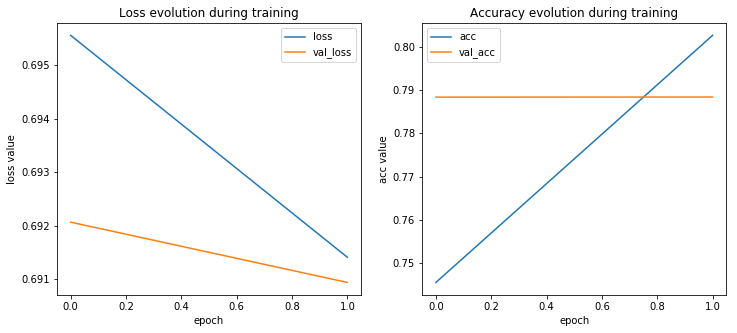

In [7]:
logs_to_graph(file_id)

### Using dataset augmentation

Now, we apply dataset augmentation using Keras' preprocessing ImageDataGenerator class. We use it, by default, to transform the original dataset images using rotations and flips. This could proove useful because most of the training dataset roads are axis-aligned, and tilted roads could be harder for our model to segment.

In [ ]:
file_id = utrain.main(
    img_height=256,
    batch_size=2,
    epochs=N_EPOCHS,
    steps_per_epoch=N_STEPS_PER_EPOCH,
    aug=True,
    chosen_validation=False,
    rgb=False,
    pretrained_weights=None,
    monitor="val_acc",
    root_folder="."
)

In [ ]:
logs_to_graph(file_id)

### Original image size

We try to use the original image size instead. This eliminates the resampling process, but results in a larger number of weights to train thus longer training times. Note that resampling to a smaller size condenses more "context" information for each pixel : the convolution kernel size is fixed, therefore a 256\*256 resampling provides to the first convolution layer 400/256 more pixel information to the kernel (if we ignore the loss of information during resampling). Nevertheless, we evaluate our model performance on the original image size.


In [ ]:
file_id = utrain.main(
    img_height=400,
    batch_size=2,
    epochs=N_EPOCHS,
    steps_per_epoch=N_STEPS_PER_EPOCH,
    aug=True,
    chosen_validation=False,
    rgb=False,
    pretrained_weights=None,
    monitor="val_acc",
    root_folder="."
)

In [ ]:
logs_to_graph(file_id)

### Using red, green and blue channels

Instead of using the grayscale of the training images, we train using directly the separate channels. This results in more weights to train thus longer training times, but also preserves more original informations about the training images.

In [ ]:
file_id = utrain.main(
    img_height=256,
    batch_size=2,
    epochs=N_EPOCHS,
    steps_per_epoch=N_STEPS_PER_EPOCH,
    aug=True,
    chosen_validation=False,
    rgb=True,
    pretrained_weights=None,
    monitor="val_acc",
    root_folder="."
)

In [ ]:
logs_to_graph(file_id)

### Using the chosen validation dataset

Instead of letting the choice of the separation of the training and validation datasets to randomness, we use a custom predetermined split. This can be useful because some training images are more exotic than others, providing more useful information to our neural network. Would it happen that most/all of those be chosen for validation, this useful information would not be used to train our network. Instead, we set a training dataset with some conventional images and also some exotic images, and a validation dataset also with some conventional and exotic images. The details of the chosen indicies can be found in the common.py file.

In [ ]:
file_id = utrain.main(
    img_height=256,
    batch_size=2,
    epochs=N_EPOCHS,
    steps_per_epoch=N_STEPS_PER_EPOCH,
    aug=True,
    chosen_validation=True,
    rgb=False,
    pretrained_weights=None,
    monitor="val_acc",
    root_folder="."
)

In [ ]:
logs_to_graph(file_id)

# Using ImageDataGenerator parameters

We try changing the parameters of ImageDataGenerator, changing rotation, adding zoom and shift. The missing pixels in each case, if any, are filled using the reflected method.

### Rotation

We try adding more rotation to ImageDataGenerator, from 90 to 360.

In [ ]:
dgargs = dict(    
    rotation_range=360, # instead of 90
    fill_mode='reflect',
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
)
file_id = utrain.main(
    img_height=256,
    batch_size=2,
    epochs=N_EPOCHS,
    steps_per_epoch=N_STEPS_PER_EPOCH,
    aug=True,
    chosen_validation=True,
    rgb=False,
    pretrained_weights=None,
    monitor="val_acc",
    root_folder=".",
    data_gen_args=dgargs
)

In [ ]:
logs_to_graph(file_id)

### Shift

We try using shifting in the x and y axis, with a maximum shift of 20% the width/height of the image.

In [ ]:
dgargs = dict(    
    rotation_range=90,
    fill_mode='reflect',
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
)
file_id = utrain.main(
    img_height=256,
    batch_size=2,
    epochs=5,
    steps_per_epoch=10,
    aug=True,
    chosen_validation=True,
    rgb=False,
    pretrained_weights=None,
    monitor="val_acc",
    root_folder=".",
    data_gen_args=dgargs
)

In [ ]:
logs_to_graph(file_id)

### Zoom

We try using zoom augmentation, of 20% the image current scale.

In [ ]:
dgargs = dict(    
    rotation_range=90,
    fill_mode='reflect',
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
)
file_id = utrain.main(
    img_height=256,
    batch_size=2,
    epochs=N_EPOCHS,
    steps_per_epoch=N_STEPS_PER_EPOCH,
    aug=True,
    chosen_validation=True,
    rgb=False,
    pretrained_weights=None,
    monitor="val_acc",
    root_folder=".",
    data_gen_args=dgargs
)

In [ ]:
logs_to_graph(file_id)